*Training model for feature - hair_color*


*Importing all necessary libraries*


In [1]:
import pandas as pd
import numpy as np
from os import listdir
import cv2 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
%matplotlib inline
from numpy import expand_dims
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


*Importing all the images which will be used for training*

A sample file name: unsplash_100233.jpg
Shape information of two arbitrary images: (64, 64, 3) - this one is shown below, and (533, 800, 3)


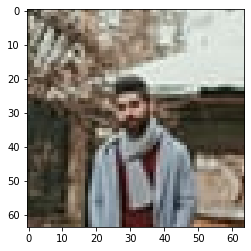

In [2]:
dir_struct = 'C:/Users/wania/Desktop/Coursework_1/images/'
file_lst = listdir(dir_struct) # it will return all the image file names as a list
print('A sample file name: {}'.format(file_lst[1]))

# Change color to RGB from OpenCV's BGR format since this library uses BGR format [rather than RGB] for historical purposes
# an interesting perspective on why OpenCV uses BGR : https://learnopencv.com/why-does-opencv-use-bgr-color-format/
image = cv2.imread(dir_struct+file_lst[1])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('Shape information of two arbitrary images: {} - this one is shown below, and {}'.format(image.shape, cv2.imread(dir_struct+file_lst[5]).shape))
plt.imshow(image)

*Importing csv file which contains annotations and creating a dataframe*

In [4]:
df  = pd.read_csv('C:/Users/wania/Desktop/Coursework_1/annotations.csv')
print('Number of images: ', df.shape[0])
print('The proportion of the different hair color labels: ')
# you may see equal proportion: logical since we have randomly assigned the label
df.hair_color.value_counts(sort=False)

Number of images:  1000
The proportion of the different hair color labels: 


0     78
1    254
2     10
3     61
4      3
5     16
6     43
7     14
8    521
Name: hair_color, dtype: int64

*Creating a new column which will hold all the images as arrays*

,image_name,wrinkles,freakles,glasses,hair_color,hair_top,no_face_shown,image
0,unsplash_612.jpg,0,0,1,0,2,0,"[[[52, 59, 52], [52, 58, 51], [56, 59, 49], [6..."
1,unsplash_952.jpg,0,1,0,1,2,0,"[[[105, 127, 100], [106, 128, 101], [107, 129,..."
2,unsplash_984.jpg,0,0,0,1,2,0,"[[[184, 61, 75], [190, 63, 80], [195, 66, 86],..."
3,unsplash_1003.jpg,0,0,0,3,2,0,"[[[186, 224, 243], [187, 226, 246], [190, 228,..."
4,unsplash_1092.jpg,0,0,0,8,3,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


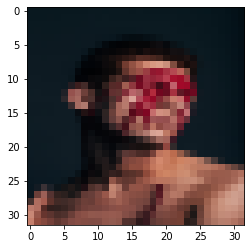

In [5]:
image_lst = [] # this list will hold all the images
#for i in range(1):
for i in range(df.shape[0]): # read the image one by one
    image = cv2.imread(dir_struct+df.iloc[i]['image_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB convert
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) # resizing all images to 32x32: NOT ideal but need to be uniform in order to apply the algorithm
                                                                                                                        # this actually ensures all the features [pixel values] will be of same size
    image_lst.append(image) # appending the read image to a list

df['image'] = image_lst # creating a new column that holds all the images
# showing the same image that we have displayed before
# see the change because of resizing
plt.imshow(df.iloc[5]['image'])
df.head(5)

*Splitting the dataset into train and test*

In [6]:
X = df.drop(['image_name','wrinkles','freakles','glasses','hair_color','hair_top','no_face_shown'], axis=1)
y = df['hair_color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state=42)

In [7]:
print('Training dataset shape: {}'.format(X_train.shape))
print('Testing dataset shape: {}'.format(X_test.shape))
print('Training dataset shape: {}'.format(y_train.shape))
print('Testing dataset shape: {}'.format(y_test.shape))

print(X_train.head(10))

print(y_train.head(2))

Training dataset shape: (700, 1)
Testing dataset shape: (300, 1)
Training dataset shape: (700,)
Testing dataset shape: (300,)
                                                 image
693  [[[28, 28, 28], [28, 28, 28], [28, 28, 28], [2...
310  [[[86, 81, 77], [108, 101, 95], [126, 119, 113...
182  [[[37, 38, 40], [36, 37, 39], [37, 38, 40], [3...
151  [[[64, 65, 67], [61, 62, 64], [33, 35, 37], [3...
610  [[[123, 111, 75], [115, 103, 64], [124, 109, 7...
507  [[[220, 245, 240], [229, 241, 241], [232, 227,...
744  [[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...
575  [[[223, 228, 232], [223, 228, 232], [224, 227,...
875  [[[198, 124, 161], [201, 127, 164], [203, 131,...
713  [[[36, 33, 26], [36, 33, 25], [39, 35, 26], [3...
693    8
310    8
Name: hair_color, dtype: int64


Converting images to (32,32,3) and using normalization

In [8]:
# manually converting it to the similar shape as our other example
X_train['image'] = X_train['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])
X_test['image'] = X_test['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])

X_train = np.reshape([x for x in X_train['image'].values], (X_train.shape[0], 32, 32, 3))
X_test = np.reshape([x for x in X_test['image'].values], (X_test.shape[0], 32, 32, 3))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)
X_train /= 255
X_test /= 255

<ipython-input-8-639a2418b2f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['image'] = X_train['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])
<ipython-input-8-639a2418b2f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['image'] = X_test['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])


In [9]:
print('Converted training dataset shape: {}'.format(X_train.shape))
print('Converted Testing dataset shape: {}'.format(X_test.shape))

Converted training dataset shape: (700, 32, 32, 3)
Converted Testing dataset shape: (300, 32, 32, 3)


In [10]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model.add(layers.Flatten())    ## converting to vector 
model.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model.add(layers.Dense(10, activation="softmax"))    ## output layer 




model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

Epoch 1/10
2/2 [==============================] - 29s 8s/step - loss: 2.3018 - accuracy: 0.5015 - val_loss: 2.2923 - val_accuracy: 0.5200
Epoch 2/10
2/2 [==============================] - 26s 8s/step - loss: 2.2894 - accuracy: 0.5195 - val_loss: 2.2421 - val_accuracy: 0.5200
Epoch 3/10
2/2 [==============================] - 26s 8s/step - loss: 2.2238 - accuracy: 0.5162 - val_loss: 1.9736 - val_accuracy: 0.5200
Epoch 4/10
2/2 [==============================] - 26s 8s/step - loss: 1.9089 - accuracy: 0.5175 - val_loss: 1.9247 - val_accuracy: 0.5200
Epoch 5/10
2/2 [==============================] - 26s 8s/step - loss: 1.8866 - accuracy: 0.5260 - val_loss: 1.5443 - val_accuracy: 0.5200
Epoch 6/10
2/2 [==============================] - 25s 7s/step - loss: 1.5591 - accuracy: 0.5221 - val_loss: 1.6566 - val_accuracy: 0.5200
Epoch 7/10
2/2 [==============================] - 24s 7s/step - loss: 1.6625 - accuracy: 0.5175 - val_loss: 1.6084 - val_accuracy: 0.4700
Epoch 8/10
2/2 [==================

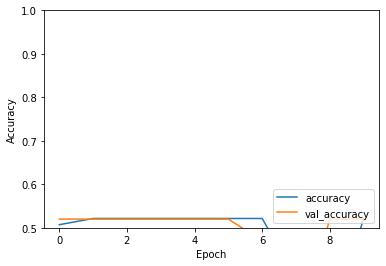

In [11]:
# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_test, y_test))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

Experimenting with more epochs and less batch size

Epoch 1/50
22/22 [==============================] - 32s 1s/step - loss: 1.4464 - accuracy: 0.5214 - val_loss: 1.4022 - val_accuracy: 0.5200
Epoch 2/50
22/22 [==============================] - 29s 1s/step - loss: 1.4525 - accuracy: 0.5214 - val_loss: 1.4012 - val_accuracy: 0.5200
Epoch 3/50
22/22 [==============================] - 28s 1s/step - loss: 1.4047 - accuracy: 0.5214 - val_loss: 1.3800 - val_accuracy: 0.5200
Epoch 4/50
22/22 [==============================] - 29s 1s/step - loss: 1.4203 - accuracy: 0.5214 - val_loss: 1.3769 - val_accuracy: 0.5200
Epoch 5/50
22/22 [==============================] - 29s 1s/step - loss: 1.4397 - accuracy: 0.5214 - val_loss: 1.4016 - val_accuracy: 0.5200
Epoch 6/50
22/22 [==============================] - 29s 1s/step - loss: 1.3993 - accuracy: 0.5214 - val_loss: 1.4165 - val_accuracy: 0.5200
Epoch 7/50
22/22 [==============================] - 29s 1s/step - loss: 1.3814 - accuracy: 0.5214 - val_loss: 1.3710 - val_accuracy: 0.5200
Epoch 8/50
22/22 [==

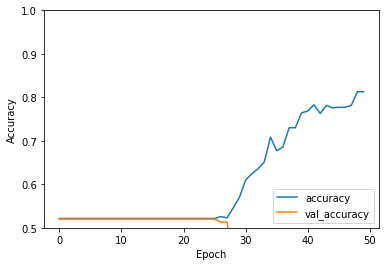

In [12]:
# Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

*Changing the learning rate, epochs and batch size*

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model.add(layers.Flatten())    ## converting to vector 
model.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model.add(layers.Dense(10, activation="softmax"))    ## output layer 




model.compile(optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

Epoch 1/50
6/6 [==============================] - 29s 4s/step - loss: 2.1400 - accuracy: 0.2798 - val_loss: 2.0767 - val_accuracy: 0.2533
Epoch 2/50
6/6 [==============================] - 25s 4s/step - loss: 1.9013 - accuracy: 0.2702 - val_loss: 1.4581 - val_accuracy: 0.5200
Epoch 3/50
6/6 [==============================] - 25s 4s/step - loss: 1.4663 - accuracy: 0.5226 - val_loss: 1.4197 - val_accuracy: 0.5200
Epoch 4/50
6/6 [==============================] - 25s 4s/step - loss: 1.3991 - accuracy: 0.5204 - val_loss: 1.4024 - val_accuracy: 0.5200
Epoch 5/50
6/6 [==============================] - 25s 4s/step - loss: 1.3456 - accuracy: 0.5394 - val_loss: 1.3912 - val_accuracy: 0.5200
Epoch 6/50
6/6 [==============================] - 25s 4s/step - loss: 1.3734 - accuracy: 0.5348 - val_loss: 1.3905 - val_accuracy: 0.5200
Epoch 7/50
6/6 [==============================] - 25s 4s/step - loss: 1.3977 - accuracy: 0.5134 - val_loss: 1.3928 - val_accuracy: 0.5200
Epoch 8/50
6/6 [==================

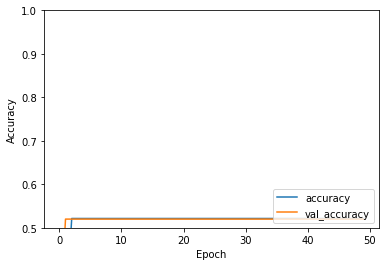

In [14]:
# Training
history = model.fit(X_train, y_train, epochs=50, batch_size=128,
                    validation_data=(X_test, y_test))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

In [19]:
predictions = model.predict(X_test)
predictions[9]

array([7.6846026e-02, 2.5830269e-01, 1.0924785e-02, 6.1671305e-02,
       2.9566751e-03, 1.5568709e-02, 4.1059598e-02, 1.5748007e-02,
       5.1678318e-01, 1.3904103e-04], dtype=float32)

In [20]:
predictions_index = np.argmax(predictions, axis=1) # Convert one-hot to index; remember indexing starts from 0; index takes integers values in [0,1]
predictions_index

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], d